In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation, MaxPooling2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [3]:
batch_size = 32  # The default batch size of keras.
num_classes = 10  # Number of class for the dataset
epochs = 1
data_augmentation = False

In [4]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [5]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)


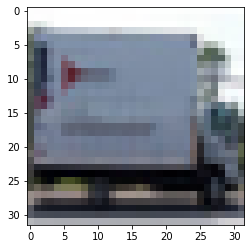

In [6]:
plt.imshow(X_train[495,:,:,:])
plt.show()

In [7]:
# Normalize the data. Before we need to connvert data type to float for computation.

X_train = X_train / 255
X_test = X_test / 255

In [8]:
# Convert class vectors to binary class matrices. This is called one hot encoding.

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [9]:

model = Sequential()

# CONV => RELU => CONV => RELU => POOL => DROPOUT

model.add(Conv2D(32, (3, 3), padding='same',input_shape=X_train.shape[1:]))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# CONV => RELU => CONV => RELU => POOL => DROPOUT

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# FLATTERN => DENSE => RELU => DROPOUT

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# a softmax classifier
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                        

In [10]:
#  Model training

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [11]:

history = None  # For recording the history of trainning process.

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), shuffle=True)

1563/1563 [==============================] - 128s 81ms/step - loss: 1.8219 - accuracy: 0.3319 - val_loss: 1.6214 - val_accuracy: 0.4166


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


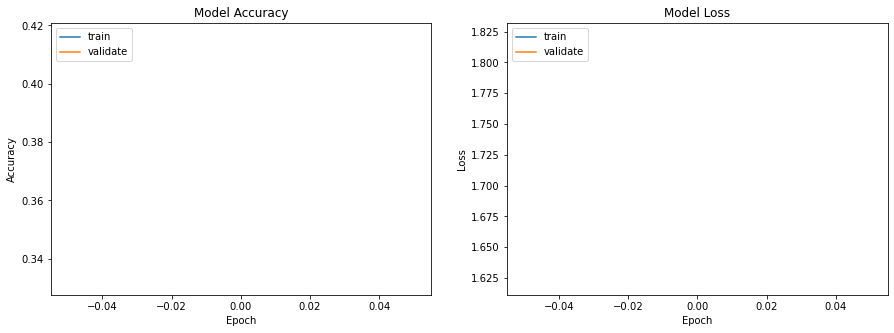

In [12]:
#Training and validation curves.

def plotmodelhistory(history): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy']) 
    axs[0].plot(history.history['val_accuracy']) 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss']) 
    axs[1].plot(history.history['val_loss']) 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())

plotmodelhistory(history)

In [13]:
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

# make prediction.
pred = model.predict(X_test)

313/313 [==============================] - 6s 19ms/step - loss: 1.6214 - accuracy: 0.4166
Test loss: 1.6213549375534058
Test accuracy: 0.41659998893737793
313/313 [==============================] - 7s 20ms/step


In [14]:
np.argmax(pred, axis=1)

array([6, 1, 8, ..., 5, 4, 7], dtype=int64)

In [15]:
#Confusion matrix.

def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.
    """
    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
    
    ax.set_xlabel('Predicted Label') 
    ax.set_ylabel('True Label')
    
    return im, cbar

def annotate_heatmap(im, data=None, fmt="d", threshold=None):
    """
    A function to annotate a heatmap.
    """
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = im.axes.text(j, i, format(data[i, j], fmt), horizontalalignment="center",
                                 color="white" if data[i, j] > thresh else "black")
            texts.append(text)

    return texts

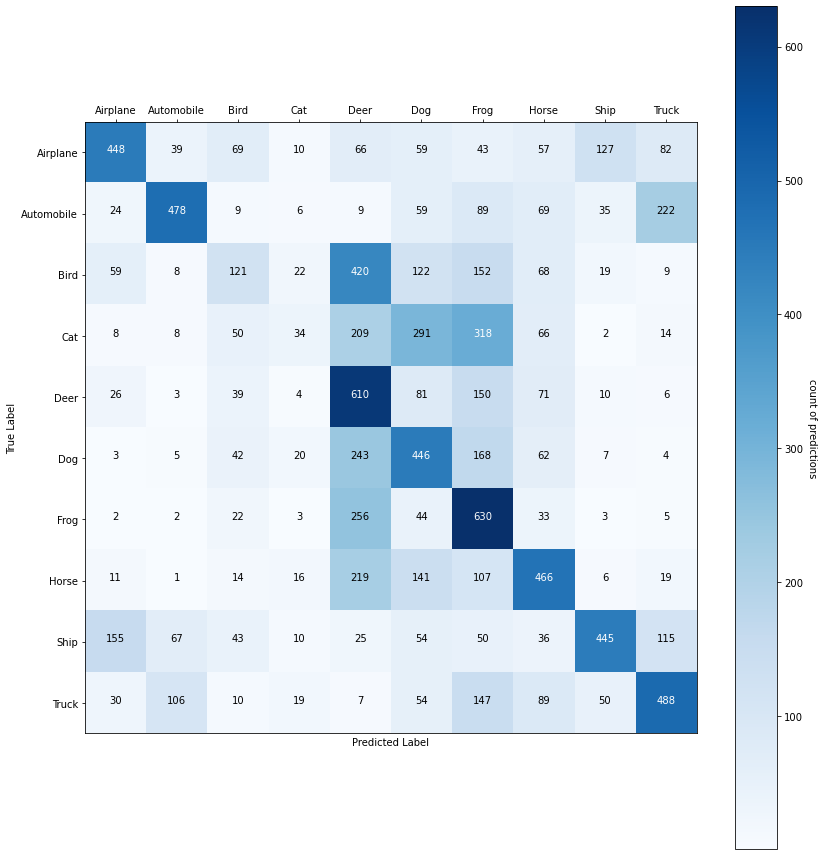

In [16]:
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred, axis=1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis=1)
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = pred[errors]
Y_true_errors = Y_true[errors]
X_test_errors = X_test[errors]

cm = confusion_matrix(Y_true, Y_pred_classes) 
thresh = cm.max() / 2.

fig, ax = plt.subplots(figsize=(12,12))
im, cbar = heatmap(cm, labels, labels, ax=ax,
                   cmap=plt.cm.Blues, cbarlabel="count of predictions")
texts = annotate_heatmap(im, data=cm, threshold=thresh)

fig.tight_layout()
plt.show()

In [17]:
# Classification report  (Precision, Recall, F1 score, etc...)

print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.58      0.45      0.51      1000
           1       0.67      0.48      0.56      1000
           2       0.29      0.12      0.17      1000
           3       0.24      0.03      0.06      1000
           4       0.30      0.61      0.40      1000
           5       0.33      0.45      0.38      1000
           6       0.34      0.63      0.44      1000
           7       0.46      0.47      0.46      1000
           8       0.63      0.45      0.52      1000
           9       0.51      0.49      0.50      1000

    accuracy                           0.42     10000
   macro avg       0.43      0.42      0.40     10000
weighted avg       0.43      0.42      0.40     10000



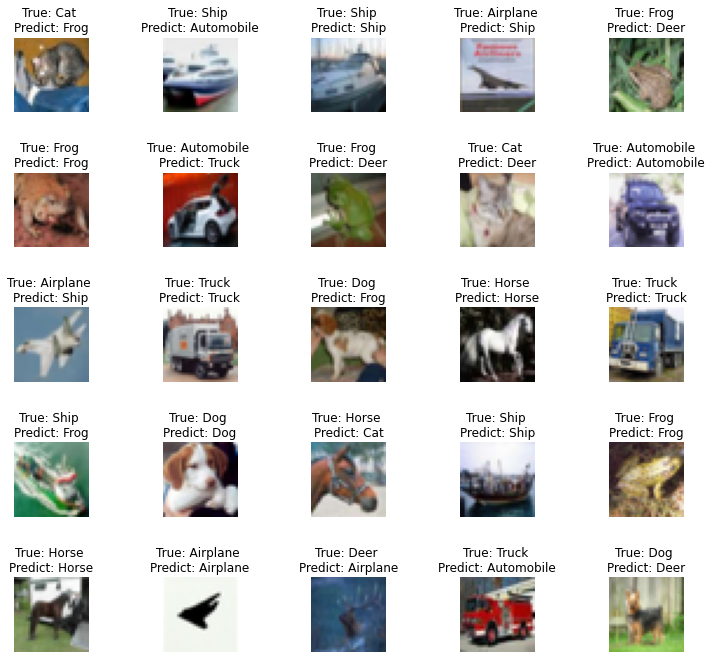

In [18]:
# Check the predictions.

R = 5
C = 5
fig, axes = plt.subplots(R, C, figsize=(12,12))
axes = axes.ravel()

for i in np.arange(0, R*C):
    axes[i].imshow(X_test[i])
    axes[i].set_title("True: %s \nPredict: %s" % (labels[Y_true[i]], labels[Y_pred_classes[i]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)

# Testing the model with the test images in the test set.

In [19]:
def show_test(number):
    fig = plt.figure(figsize = (3,3))
    test_image = np.expand_dims(X_test[number], axis=0)
    test_result = model.predict(test_image)
    Y_pred_classes = np.argmax(test_result, axis=1) 
    plt.imshow(X_test[number])
    dict_key = Y_pred_classes[0]
    print(dict_key)
    plt.title("Predicted: {} \nTrue Label: {}".format(labels[dict_key],labels[Y_true[number]]))

1/1 [==============================] - 0s 34ms/step
9


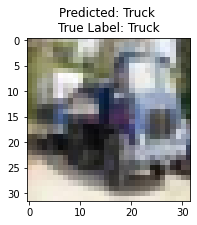

In [20]:
show_test(28)

In [21]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(Y_true,Y_pred_classes)
cm

array([[448,  39,  69,  10,  66,  59,  43,  57, 127,  82],
       [ 24, 478,   9,   6,   9,  59,  89,  69,  35, 222],
       [ 59,   8, 121,  22, 420, 122, 152,  68,  19,   9],
       [  8,   8,  50,  34, 209, 291, 318,  66,   2,  14],
       [ 26,   3,  39,   4, 610,  81, 150,  71,  10,   6],
       [  3,   5,  42,  20, 243, 446, 168,  62,   7,   4],
       [  2,   2,  22,   3, 256,  44, 630,  33,   3,   5],
       [ 11,   1,  14,  16, 219, 141, 107, 466,   6,  19],
       [155,  67,  43,  10,  25,  54,  50,  36, 445, 115],
       [ 30, 106,  10,  19,   7,  54, 147,  89,  50, 488]], dtype=int64)